In [1]:
import time
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

import os
import copy
import math

from scipy.special import softmax
import scipy.stats as ss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,recall_score,precision_score,precision_recall_curve,f1_score,auc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES']='1'

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [2]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0.0001, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >self.patience:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
class mtlAttention(nn.Module):
    def __init__(self, In_Nodes1,In_Nodes2, Modules):
        super(mtlAttention, self).__init__()
        self.Modules = Modules
        self.sigmoid = nn.Sigmoid()

        self.task1_FC1_x = nn.Linear(In_Nodes1, Modules,bias=False)
        self.task1_FC1_y = nn.Linear(In_Nodes1, Modules,bias=False)

        self.task2_FC1_x = nn.Linear(In_Nodes2, Modules,bias=False)
        self.task2_FC1_y = nn.Linear(In_Nodes2, Modules,bias=False)
            
        self.softmax  = nn.Softmax(dim=-1)
        
        self.task1_FC2 =nn.Sequential(nn.Linear(Modules*2, 32),nn.ReLU())
        self.task2_FC2 = nn.Sequential(nn.Linear(Modules*2, 32),nn.ReLU())

        self.task1_FC3 =nn.Sequential(nn.Linear(32, 16),nn.ReLU())
        self.task2_FC3 = nn.Sequential(nn.Linear(32, 16),nn.ReLU())
        
        self.task1_FC4 = nn.Sequential(nn.Linear(16, 1), nn.Sigmoid())
        self.task2_FC4 = nn.Sequential(nn.Linear(16, 1), nn.Sigmoid())

    def forward_one(self,xg,xm):
        xg_x = self.task1_FC1_x(xg)
        xm_x = self.task2_FC1_x(xm)
        xg_y = self.task1_FC1_y(xg)         
        xm_y =self.task2_FC1_y(xm)

        xg = torch.cat([xg_x.reshape(-1,1,self.Modules),xg_y.reshape(-1,1,self.Modules)], dim=1)
        xm = torch.cat([xm_x.reshape(-1,1,self.Modules),xm_y.reshape(-1,1,self.Modules)], dim=1)
        
        norm  = torch.norm(xg, dim=1, keepdim=True)
        xg = xg.div(norm)
        
        norm  = torch.norm(xm, dim=1, keepdim=True)
        xm = xm.div(norm)
        
        energy =  torch.bmm(xg.reshape(-1,2,self.Modules).permute(0,2,1) ,xm.reshape(-1,2,self.Modules))
        attention1 = self.softmax(energy.permute(0,2,1)).permute(0,2,1) 
        attention2 = self.softmax(energy).permute(0,2,1)
        
        xg_value = torch.bmm(xg,attention1) 
        xm_value = torch.bmm(xm,attention2)

        xg = xg_value.view(-1,self.Modules*2)
        xm =xm_value.view(-1,self.Modules*2)
        
        xg = self.task1_FC2(xg)
        xm = self.task2_FC2(xm) 
        xg = self.task1_FC3(xg)
        xm = self.task2_FC3(xm)
        xg = self.task1_FC4(xg)
        xm = self.task2_FC4(xm)
        
        return xg,xm

In [4]:
### Toy Dataset load
xg_data = pd.read_csv('/user_home/moons/SHOT/toy_GE.csv',index_col=0)
xm_data = pd.read_csv('/user_home/moons/SHOT/toy_me.csv',index_col=0)

print(xg_data.shape)
print(xm_data.shape)

(10000, 200)
(10000, 200)


In [5]:
label = pd.DataFrame(xg_data.columns)
label.loc[label[0].str.contains('AD')] = 1
label.loc[label[0]!=1] = 0 
label = np.ravel(label, order='F').astype('float32')

In [6]:
xg_data = xg_data.T
xm_data = xm_data.T

xg_data = xg_data.values
xm_data = xm_data.values

In [7]:
### Train

start = time.time()
j=0
for train_index, test_index in skf.split(xg_data,label):
    Xg_train, Xg_test = xg_data[train_index,:], xg_data[test_index,:]
    Xm_train, Xm_test = xm_data[train_index,:], xm_data[test_index,:]
    yg_train, yg_test = label[train_index], label[test_index]
    j=j+1
    if j==1: ### CV1 test
        break

earlyStoppingPatience = 100
learningRate = 0.000005
weightDecay = 0.001
num_epochs = 500000 

y_train = yg_train.flatten().astype(int)
y_test = yg_test.flatten().astype(int)

Xg = torch.tensor(Xg_train, dtype=torch.float32).cuda()
Xm = torch.tensor(Xm_train, dtype=torch.float32).cuda()

Xg_test = torch.tensor(Xg_test, dtype=torch.float32).cuda()
Xm_test = torch.tensor(Xm_test, dtype=torch.float32).cuda()

y = torch.tensor(y_train, dtype=torch.float32).cuda()

ds = TensorDataset(Xg, Xm,y)
loader  = DataLoader(ds, batch_size=y_train.shape[0],shuffle=True)

Xg_test = torch.tensor(Xg_test, dtype=torch.float32).cuda()
Xm_test = torch.tensor(Xm_test, dtype=torch.float32).cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
In_Nodes1 = Xg_train.shape[1] 
In_Nodes2 = Xm_train.shape[1]

net = mtlAttention(In_Nodes1,In_Nodes2,32)
net = net.to(device)
early_stopping = EarlyStopping(patience=earlyStoppingPatience, verbose=False)
optimizer = optim.Adam(net.parameters(), lr=learningRate, weight_decay=weightDecay)
loss_fn = nn.BCELoss()

for epoch in (range(num_epochs)):
    running_loss1 = 0.0
    running_loss2 = 0.0
    for i, data in enumerate(loader, 0):
        xg,xm, y = data
        output1,output2 = net.forward_one(xg,xm)
        output1  = output1.squeeze()
        output2  = output2.squeeze()
        net.train()
        optimizer.zero_grad()
        loss = loss_fn(output1, y) + loss_fn(output2, y) 
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss1 += loss_fn(output1,y.view(-1)).item()
        running_loss2 += loss_fn(output2,y.view(-1)).item()


    early_stopping(running_loss1+running_loss2, net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("--------------------------------------------------------------------------------------------------")
        break

    if (epoch+1) % 2000 == 0 or epoch == 0:
        if (epoch+1) % 2000 == 0 or epoch == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}, BCE_task1; {:.4f}, BCE_task2; {:.4f}'.format(epoch+1,num_epochs, running_loss1+running_loss2,running_loss1,running_loss2))

### Test
            
test1,test2 = net.forward_one(Xg_test.clone().detach(),Xm_test.clone().detach())
test1 = test1.cpu().detach().numpy()
test2 = test2.cpu().detach().numpy()


print ("ACC_task1 %.3f, ACC_task2 %.3f" %(accuracy_score(list(y_test),np.where(test1 > 0.5, 1, 0) ),accuracy_score(list(y_test),np.where(test2 > 0.5, 1, 0))))
print ("F1_task1 %.3f, F1_task2 %.3f" %(f1_score(list(y_test),np.where(test1 > 0.5, 1, 0)),f1_score(list(y_test),np.where(test2 > 0.5, 1, 0))))
print ("AUC_task1 %.3f, AUC_task2 %.3f" %(roc_auc_score(y_test.reshape(-1),test1),roc_auc_score(y_test.reshape(-1),test2)))
print("time :", time.time() - start)

/user_home/moons/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/user_home/moons/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/500000], Loss: 1.3900, BCE_task1; 0.6963, BCE_task2; 0.6937
Epoch [2000/500000], Loss: 1.0499, BCE_task1; 0.5520, BCE_task2; 0.4979
Epoch [4000/500000], Loss: 0.7864, BCE_task1; 0.4367, BCE_task2; 0.3498
Epoch [6000/500000], Loss: 0.5394, BCE_task1; 0.3217, BCE_task2; 0.2177
Epoch [8000/500000], Loss: 0.3437, BCE_task1; 0.2210, BCE_task2; 0.1227
Epoch [10000/500000], Loss: 0.2061, BCE_task1; 0.1410, BCE_task2; 0.0651
Epoch [12000/500000], Loss: 0.1091, BCE_task1; 0.0771, BCE_task2; 0.0320
Epoch [14000/500000], Loss: 0.0560, BCE_task1; 0.0407, BCE_task2; 0.0153
Epoch [16000/500000], Loss: 0.0268, BCE_task1; 0.0196, BCE_task2; 0.0072
Epoch [18000/500000], Loss: 0.0131, BCE_task1; 0.0095, BCE_task2; 0.0036
Epoch [20000/500000], Loss: 0.0067, BCE_task1; 0.0046, BCE_task2; 0.0021
Early stopping
--------------------------------------------------------------------------------------------------
ACC_task1 0.675, ACC_task2 0.675
F1_task1 0.649, F1_task2 0.698
AUC_task1 0.770, AUC_task2 

In [11]:
### Calculate similarity Score

y_all = np.concatenate((y_train,y_test+2))
Xg_all = np.concatenate((Xg_train,Xg_test.cpu().detach().numpy()))
Xm_all = np.concatenate((Xm_train,Xm_test.cpu().detach().numpy()))
att_all = pd.DataFrame()
sum_all = pd.DataFrame(np.zeros((dim*dim, 1)))

for i in range(y_all.shape[0]):
    xg_x = net.task1_FC1_x(torch.tensor(Xg_all[i].reshape(1,-1)).float().cuda())
    xg_y = net.task1_FC1_y(torch.tensor(Xg_all[i].reshape(1,-1)).float().cuda())
    xm_x = net.task2_FC1_x(torch.tensor(Xm_all[i].reshape(1,-1)).float().cuda())
    xm_y = net.task2_FC1_y(torch.tensor(Xm_all[i].reshape(1,-1)).float().cuda())
    xg = torch.cat([xg_x.reshape(-1,1,dim),xg_y.reshape(-1,1,dim)], dim=1)
    xm = torch.cat([xm_x.reshape(-1,1,dim),xm_y.reshape(-1,1,dim)], dim=1)

    norm  = torch.norm(xg, dim=1, keepdim=True)
    xg = xg.div(norm)
    norm2  = torch.norm(xm, dim=1, keepdim=True)
    xm = xm.div(norm2)

    energy =  torch.bmm(xg.reshape(-1,2,dim).permute(0,2,1) ,xm.reshape(-1,2,dim)) 
    att = energy.cpu().detach().numpy().reshape(dim,dim)

    ind = np.empty([dim,dim]).astype(str)
    for a in range(dim):
        for b in range(dim):
            st = 'GE module %s, DM module %s' %(a,b)
            ind[a,b] = st
    atte2 = pd.DataFrame(att.reshape(-1,1),index=ind.reshape(-1,1))
    att_all = pd.concat([att_all,atte2],axis=1)
    if y_all[i]==1:
        sum_all = sum_all.add(atte2, fill_value=0)
sum_all = sum_all[dim*dim:]

/user_home/moons/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/indexes/base.py:3519: RuntimeWarning: '<' not supported between instances of 'tuple' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)


/user_home/moons/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


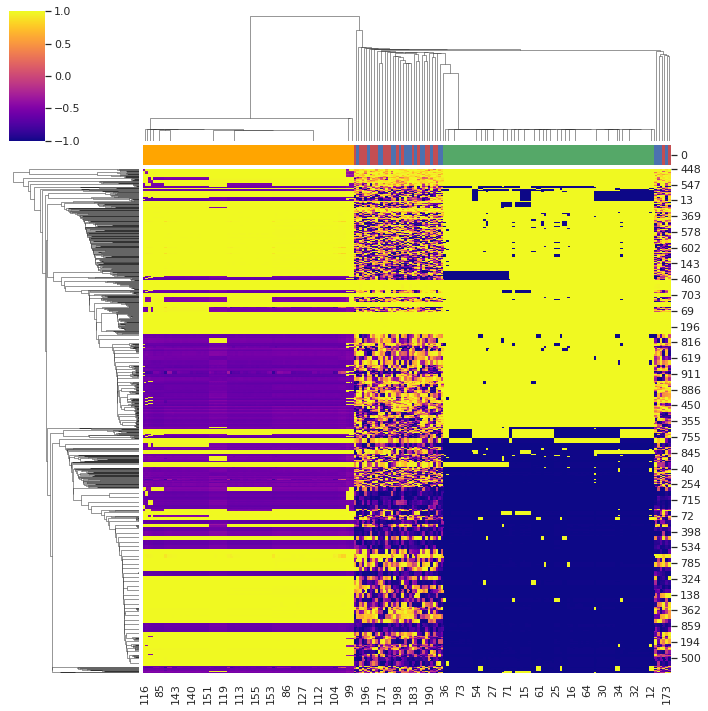

In [12]:
### Visualization Similarity Score

my_palette =  dict(zip(np.unique(y_all), "rbg"))
my_palette[0]  = 'g'
my_palette[1]  = 'orange'
my_palette[2]  = 'b'
my_palette[3]  = 'r'
row_colors = pd.DataFrame(y_all)[0].map(my_palette)

cluster = sns.clustermap(pd.DataFrame(att_all.values), metric="correlation", method="single", cmap="plasma", col_colors=row_colors,row_cluster=True,dendrogram_ratio=0.2)